# Parameter sensitivity study - loop 01 results overview


Parameter sensitivity study - Loop 1 was performed for 3 board states available in library, chosen manually so that there is wide enough range of possible error outcomes.

n=100 repetitions for each set.

Parameter sets tested:

                    75%, 80%, 85%, 90%, 95%, 97%
conf_level_values = [1.15, 1.28, 1.44, 1.65, 1.96, 2.17]

margin_estim_values = [0.16, 0.14, 0.12, 0.10, 0.08, 0.06, 0.04]

margin_highest_values = [0.16, 0.14, 0.12, 0.10, 0.08, 0.06, 0.04]

# Load result files

Load the sensitivity study results file from loop 01. It contains 3 board states: 

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy import stats

pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 1700)
pd.set_option('display.max_columns', 20)
pd.set_option('max_colwidth', 2000)

param_sens_study_dir = "param_sens_study\\L01"
param_sens_study_file = "param_sens_study_file.csv"
param_sens_study_path = os.path.join(param_sens_study_dir, param_sens_study_file)

df = pd.read_csv(param_sens_study_path)
print(df.dtypes)

print('Results loaded for the following board states:')
print(df['board_state_100chars_code'].unique())



board_state_100chars_code     object
conf_level                   float64
margin_est                   float64
margin_highest               float64
rel_error                    float64
time_mc                      float64
dtype: object
Results loaded for the following board states:
['7700707077270000007327070000737700000073000007007770007070000070000000000001070000070000000000070000'
 '0737700000073707000007370077770777007227700000777700007000000000070000000000700077777700007444470000'
 '7270007000727000000077707000000007077777007007333700000777777000000070070000000700777700000072270000']


Load 'times_adv' file, which contains data about calculation time using advanced algorithm

In [2]:
times_adv_dir = "times_adv\\"
times_adv_file = "times_adv_file.npy"
times_adv_path = os.path.join(times_adv_dir, times_adv_file)

adv_times_numpy = np.load(times_adv_path)

adv_times_df = pd.DataFrame(adv_times_numpy)
adv_times_df.columns = ['board_state_100chars_code', 'time_adv']
adv_times_df['time_adv'] = adv_times_df['time_adv'].apply(pd.to_numeric, errors='coerce')

print(adv_times_df.sample(5))


                                                                                 board_state_100chars_code  time_adv
1005  0000070000000000700000077700000007570000700757000700075700770007577774000757737401077773740070707374     81.04
1588  0000700700077700707007570007000757070077775777707207577277720757727077777777770000007777770000744447      0.10
333   3337444470777777777000700722700777777777775555570007777777000000000000700000000007000000000070070000      2.52
4796  0000722747000077774700700007470007000747700077777700007270000000727000000077700777777707005555570000      1.68
1725  0007444470070777777070700073770701007370700000737700700077700707777777000733372777777777277555557777      0.03


# Count and visualize inconsistent results

Results are inconsistent if the relative error in probabilistic method (MC) is higher than defined margin_highest parameter. That can happen with low confidence level.

Let's investigate how often it happens depending on confidence level used. Additionaly, average exceedance (in %) of allowed margin_highest is calculated for those cases.

   conf_level  inc_count  avg_perc_exceedance  total  perc_inc
0        1.15        700                 43.0  14700      4.76
1        1.28        482                 38.0  14700      3.28
2        1.44        301                 34.0  14700      2.05
3        1.65        146                 30.0  14700      0.99
4        1.96         32                 23.0  14700      0.22
5        2.17         16                 15.0  14700      0.11


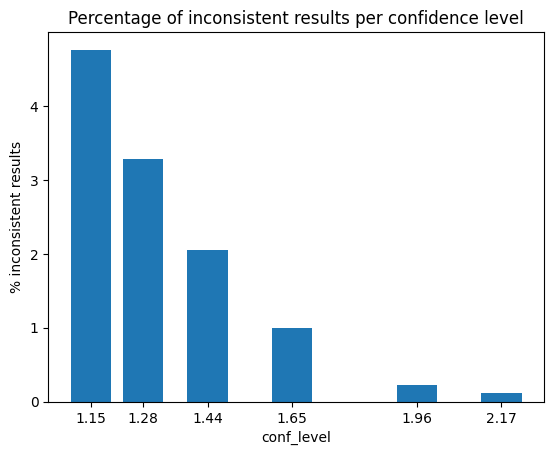

In [3]:
tot_per_conf = df.groupby('conf_level', as_index=False).count()

df['is_inconsistent'] = (df['rel_error'] > df['margin_highest'])
df['exceedance'] = np.where(df['rel_error'] > df['margin_highest'],
                            (df['rel_error'] / df['margin_highest'] - 1) * 100,
                            np.nan)

inc_plot = df.groupby('conf_level', as_index=False).agg(
    inc_count = ('is_inconsistent', 'sum'),
    avg_perc_exceedance = ('exceedance', 'mean')
)

inc_plot['total'] = inc_plot['conf_level'].map(tot_per_conf.set_index('conf_level')['rel_error'])
inc_plot['perc_inc'] = inc_plot['inc_count'] / inc_plot['total'] * 100

inc_plot['avg_perc_exceedance'] = inc_plot['avg_perc_exceedance'].round(0)
inc_plot['perc_inc'] = inc_plot['perc_inc'].round(2)
print(inc_plot)

###### PLOT INCONSISTENT RESULTS PER CONF_LEVEL #######
plt.bar(inc_plot['conf_level'], inc_plot['perc_inc'], width=0.1)
plt.title('Percentage of inconsistent results per confidence level')
plt.xlabel('conf_level')
plt.ylabel("% inconsistent results")
plt.xticks(inc_plot['conf_level'])
plt.show()


As expected, the lower the confidence level, the more frequent and severe the inconsistencies become.

Just by looking at this, I already know that I don't want to be using a conf_level lower than 1.96. Regardless of what average error I'm getting, I don't feel comfortable not knowing for sure if the maximum error limits that I set are exceeded or not. Confidence level must be high enough to make me confident, that if I set margin_highest to e.g. 10%, I won't be getting anything higher than that. Or in worst case, it will be exceeded very rarely and not by much.

# Aggregate & Normalize

##### Aggregate series of repetitive runs for the same board_state and parameters

In [4]:
avg_res = df.groupby(['board_state_100chars_code', 'conf_level', 'margin_est', 'margin_highest'], as_index=False).agg(
    rel_error = ('rel_error', 'mean'),
    time_mc = ('time_mc', 'mean'),
    max_error = ('rel_error', 'max'),
    )
print(avg_res.sample(5))


                                                                                board_state_100chars_code  conf_level  margin_est  margin_highest  rel_error  time_mc  max_error
37   0737700000073707000007370077770777007227700000777700007000000000070000000000700077777700007444470000        1.15        0.14            0.08   0.027577   0.2414    0.13859
302  7270007000727000000077707000000007077777007007333700000777777000000070070000000700777700000072270000        1.15        0.06            0.06   0.017142   0.6121    0.14010
816  7700707077270000007327070000737700000073000007007770007070000070000000000001070000070000000000070000        1.96        0.12            0.12   0.006008   1.3490    0.03004
260  0737700000073707000007370077770777007227700000777700007000000000070000000000700077777700007444470000        2.17        0.08            0.06   0.001011   1.5978    0.05055
588  7700707077270000007327070000737700000073000007007770007070000070000000000001070000070000000000070000        1.

##### Normalize average error to 0.5%

Normalization is necessary in order to aggregate and compare data from different board states 

0.5% is an acceptable level of average error, that I will use as a reference point and compare rest of results to it.

error_normalized is expressed as % of 0.5% error


In [5]:
avg_res['error_normalized'] = avg_res['rel_error'] / 0.005 * 100


##### Normalize time
For each board state find minimum time_mc for which ['error_normalized'] < 100. This will be reference time

time_normalized is expressed as % of time needed to achieve reference point error (0.5%)

For example, time_normalized = 200 means it takes twice as long as reference, so we should expect lower error

Additionally, attach a new column with information about time_adv for each board state

In [6]:
avg_res_per_game = avg_res.loc[(avg_res['error_normalized'] < 100)]

avg_res_per_game = avg_res_per_game.groupby(['board_state_100chars_code'], as_index=False).agg(
    time_at_100_error = ('time_mc', 'min'),
    )

# Map 'time_at_100_error' and 'time_adv' to original avg_res dataframe
avg_res['time_at_100_error'] = avg_res['board_state_100chars_code'].map(avg_res_per_game.set_index('board_state_100chars_code')['time_at_100_error'])
avg_res['time_adv'] = avg_res['board_state_100chars_code'].map(adv_times_df.set_index('board_state_100chars_code')['time_adv'])

# Normalize 'time_mc' as percentage of 'time_at_100_error'
avg_res['time_normalized'] = avg_res['time_mc'] / avg_res['time_at_100_error'] * 100

# Normalize advanced time as percentage of 'time_at_100_error'
avg_res['time_adv'] = avg_res['board_state_100chars_code'].map(adv_times_df.set_index('board_state_100chars_code')['time_adv'])
avg_res['time_adv_normalized'] = avg_res['time_adv'] / avg_res['time_at_100_error'] * 100

print(avg_res.sample(20))

                                                                                board_state_100chars_code  conf_level  margin_est  margin_highest  rel_error  time_mc  max_error  error_normalized  time_at_100_error  time_adv  time_normalized  time_adv_normalized
247  0737700000073707000007370077770777007227700000777700007000000000070000000000700077777700007444470000        2.17        0.04            0.08   0.004648   1.1814    0.05055            92.956             0.6696     18.61       176.433692          2779.271207
551  7270007000727000000077707000000007077777007007333700000777777000000070070000000700777700000072270000        2.17        0.06            0.14   0.009961   0.7486    0.08256           199.220             0.9737      7.27        76.881997           746.636541
285  0737700000073707000007370077770777007227700000777700007000000000070000000000700077777700007444470000        2.17        0.14            0.14   0.013295   0.4432    0.11931           265.894             0.6696 

# Create score metrics

Set up a score metrics which promotes those parameters' sets which roduce results more accurately and faster than reference set.

3 similar metrics are created, differing in weights assigned to precision increase and time decrease.

I leave it open to decide whether I care more about optimizing precision or calculation time (approach may vary dependingo on board state for example)

In [7]:
t_norm = avg_res['time_normalized']
t_value = avg_res['time_mc']
e_norm = avg_res['error_normalized']

change_in_error = (e_norm - 100)  # Increases score if negative
change_in_time = (t_norm - 100)   # Increases score if negative
time_vs_error_factor = 2          # How much more we care about precision increase than time decrease

# Main score metrics by which results will be sorted
avg_res['score'] = -1 * (change_in_error * time_vs_error_factor + change_in_time)

# Different variants to compare
avg_res['score_1'] = -1 * (change_in_error * 1 + change_in_time)
avg_res['score_2'] = -1 * (change_in_error * 2 + change_in_time)
avg_res['score_4'] = -1 * (change_in_error * 4 + change_in_time)

print(avg_res.sample(10))

                                                                                board_state_100chars_code  conf_level  margin_est  margin_highest  rel_error  time_mc  max_error  error_normalized  time_at_100_error  time_adv  time_normalized  time_adv_normalized       score     score_1     score_2      score_4
853  7700707077270000007327070000737700000073000007007770007070000070000000000001070000070000000000070000        2.17        0.08            0.16   0.003605   1.1405    0.03004            72.096             0.8529    658.85       133.720249         77248.211983   22.087751   -5.816249   22.087751    77.895751
501  7270007000727000000077707000000007077777007007333700000777777000000070070000000700777700000072270000        1.96        0.06            0.12   0.009507   0.7450    0.08256           190.148             0.9737      7.27        76.512273           746.636541 -156.808273  -66.660273 -156.808273  -337.104273
345  72700070007270000000777070000000070777770070073337000007777770

# Group by parameters

Group by unique parameters set, average across board_states

(searching for parameters set that in universally good, not only in one specific game setup)

In [8]:
avg_res = avg_res.groupby(['conf_level', 'margin_est', 'margin_highest'], as_index=False).agg(
    max_error = ('max_error', 'max'),
    avg_error_normalized = ('error_normalized', 'mean'),
    avg_time_normalized = ('time_normalized', 'mean'),
    avg_score = ('score', 'mean'),
    avg_score_1 = ('score_1', 'mean'),
    avg_score_2 = ('score_2', 'mean'),
    avg_score_4 = ('score_4', 'mean'),
    )

print(avg_res.sample(10).sort_values(by = 'avg_score'))

     conf_level  margin_est  margin_highest  max_error  avg_error_normalized  avg_time_normalized   avg_score  avg_score_1  avg_score_2  avg_score_4
40         1.15        0.14            0.14    0.25554            577.968000            24.959386 -880.895386  -402.927386  -880.895386 -1836.831386
90         1.28        0.14            0.16    0.14010            567.108667            25.575901 -859.793235  -392.684568  -859.793235 -1794.010568
124        1.44        0.10            0.14    0.14010            443.329333            42.902186 -629.560853  -286.231519  -629.560853 -1316.219519
36         1.15        0.14            0.06    0.33747            293.481333            84.496881 -371.459548  -177.978215  -371.459548  -758.422215
135        1.44        0.14            0.08    0.14010            202.474667            92.451873 -197.401206   -94.926540  -197.401206  -402.350540
200        1.96        0.04            0.12    0.08256            144.796667           121.440648 -111.033

# Filter results

Discard those parameters which produce unsatisfactory results

In [9]:
# Discard parameters which resulted in max_error higher than 25%
reduced = avg_res.query('max_error < 0.25')

# Discard parameters below given score metrics
sc_limit = -500
reduced = reduced.query('avg_score_1 >= @sc_limit & avg_score_2 >= @sc_limit & avg_score_4 >= @sc_limit & avg_time_normalized < 5000')

# Discard confidence levels that produce inconsintent results
reduced = reduced.query('conf_level >= 1.96')

print(reduced.sample(10).sort_values(by = 'avg_score'))

     conf_level  margin_est  margin_highest  max_error  avg_error_normalized  avg_time_normalized   avg_score  avg_score_1  avg_score_2  avg_score_4
273        2.17        0.12            0.04    0.00000              0.000000           632.606596 -332.606596  -432.606596  -332.606596  -132.606596
245        2.17        0.04            0.04    0.00000              0.000000           597.133883 -297.133883  -397.133883  -297.133883   -97.133883
221        1.96        0.10            0.12    0.11931            211.990667            99.465771 -223.447104  -111.456437  -223.447104  -447.428437
217        1.96        0.10            0.04    0.00000              0.000000           461.384014 -161.384014  -261.384014  -161.384014    38.615986
253        2.17        0.06            0.06    0.05055             16.773333           381.739922 -115.286589  -198.513256  -115.286589    51.166744
249        2.17        0.04            0.12    0.13859            132.208000           145.747740 -110.163

# Visualize Data

#### Scatter plot - all averaged results (before filtering)
Simple plot of normalized error vs time for all data points, just to see the shape of the curve that is formed

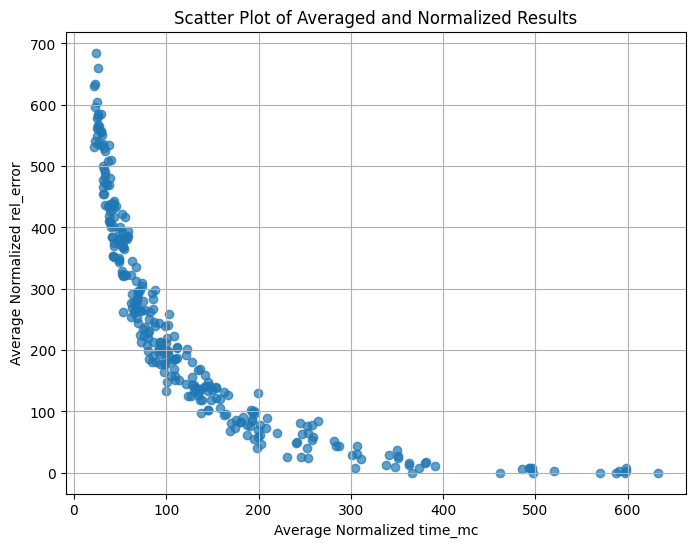

In [10]:

#################################################################################
# Scatter plot - all averaged results
plt.figure(figsize=(8, 6))
plt.scatter(avg_res.avg_time_normalized, avg_res.avg_error_normalized, alpha=0.7)
plt.xlabel('Average Normalized time_mc')
plt.ylabel('Average Normalized rel_error')
plt.title('Scatter Plot of Averaged and Normalized Results')
plt.grid(True)
# plt.legend()
plt.show()


Curve shape matches the expectations more or less. Reference at point 100,100 also seems reasonably well placed.

## Influence of each parameter

Now comes the most important part - Grouping results by different parameters to see their individual influence

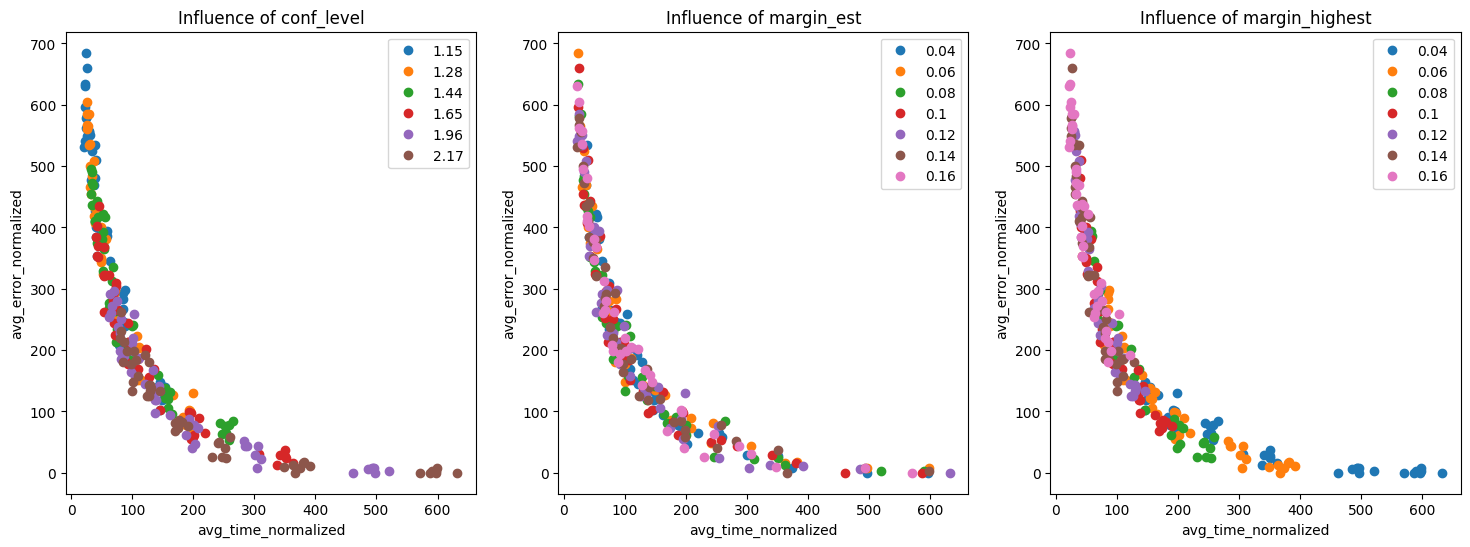

In [11]:

#################################################################################
# Group results by different parameters to see their individual influence
groups_conf_level = avg_res.groupby('conf_level')
groups_margin_est = avg_res.groupby('margin_est')
groups_margin_highest = avg_res.groupby('margin_highest')

# Plots by group
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
for name, group in groups_conf_level:
    plt.plot(group.avg_time_normalized, group.avg_error_normalized, marker='o', linestyle='', markersize=6, label=name)
    plt.title('Influence of conf_level')
    plt.xlabel('avg_time_normalized')
    plt.ylabel("avg_error_normalized")
plt.legend()

plt.subplot(1, 3, 2)
for name, group in groups_margin_est:
    plt.plot(group.avg_time_normalized, group.avg_error_normalized, marker='o', linestyle='', markersize=6, label=name)
    plt.title('Influence of margin_est')
    plt.xlabel('avg_time_normalized')
    plt.ylabel("avg_error_normalized")
plt.legend()

plt.subplot(1, 3, 3)
for name, group in groups_margin_highest:
    plt.plot(group.avg_time_normalized, group.avg_error_normalized, marker='o', linestyle='', markersize=6, label=name)
    plt.title('Influence of margin_highest')
    plt.xlabel('avg_time_normalized')
    plt.ylabel("avg_error_normalized")
plt.legend()

plt.show()


Confidence level and margin_highest - no surprise, the higher they are, the more accurate results they yield, but at the cost of longer computational time.

Margin_est - really happy to see there's no real influence of it. That is because the calculation is more often driven by margin_highest, as in the end we only care about the accuracy of determination of the best field's probability, not all other fields. Removing this parameter from the study will considerably narrow down the search.

## Scatter plot - reduced results

Simple plot of normalized error vs time for filetered data points, focused on the best region

Color map:  higher score = lower transparency

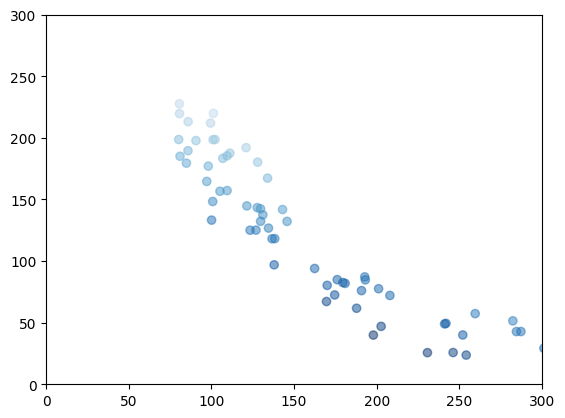

In [12]:
x = reduced['avg_time_normalized']
y = reduced['avg_error_normalized']
plt.xlim([0,300])
plt.ylim([0,300])
c  =  reduced['avg_score']

plt.scatter(x, y, c=c, alpha=0.5, cmap='Blues')
plt.show()


# Summary and conclusions

Let's again investigate the filtered results sorted by score:


In [13]:
print(reduced.sort_values(by = 'avg_score'))

     conf_level  margin_est  margin_highest  max_error  avg_error_normalized  avg_time_normalized   avg_score  avg_score_1  avg_score_2  avg_score_4
273        2.17        0.12            0.04    0.00000              0.000000           632.606596 -332.606596  -432.606596  -332.606596  -132.606596
252        2.17        0.06            0.04    0.05055              6.740000           598.633039 -312.113039  -405.373039  -312.113039  -125.593039
280        2.17        0.14            0.04    0.05055              3.370000           598.212296 -304.952296  -401.582296  -304.952296  -111.692296
245        2.17        0.04            0.04    0.00000              0.000000           597.133883 -297.133883  -397.133883  -297.133883   -97.133883
259        2.17        0.08            0.04    0.05055              3.370000           590.253691 -296.993691  -393.623691  -296.993691  -103.733691
266        2.17        0.10            0.04    0.00000              0.000000           587.216662 -287.216


Conclusions on what to do in next loop of this study:
1. Remove confidence levels lower than 1.96. Add some more confidence levels higher that 2.17, because 2.17 results are among the best (maybe higher will be even better?)
2. Remove margin_est from the study (a value of 1.0 will be always applied)
3. Add higher values of margin_highest (up to 0.30) to see where exactly it gets too high.